<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/1_Creating_an_unbiased_universe_for_cross_sectional_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1:  Creating an unbiased universe for cross-sectional analysis

In this notebook, we create an unbiased universe for cross-sectional analysis of cryptocurrency returns.

First, we load dependencies and price data from the coinmetrics dataset.

Then we remove instruments we don't want (stablecoin, wrapped tokens, duplicate coins etc).

Then, as our universe, we pick the top n by market cap on the previous day.

We don't throw away price observations but, rather, we simply flag each ticker/date observation with whether the asset was in the universe on that date.

Analysis of the returns suggests that the coinmetrics coin selection may upward bias the dataset somewhat, despite our care with building this universe. We must be aware of this potential in all our analysis using this dataset.

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', 'roll'), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpPq9sau/remotesca2ec14498/RWLab-rwRtools-1924b0b/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.33.tar.gz’



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()
# snippet: rw crypto quickstart v.0.1
quicksetup(pod = "Crypto", path = ".")
head(prices)

Authorization successful!

Set default bucket name to 'crypto_research_pod'



Attempting download of  coinmetrics.csv ...
Transferring coinmetrics.csv ... data is 2.4 Mb please be patient...


ℹ Downloading coinmetrics.csv

✔ Saved coinmetrics.csv to ./coinmetrics.csv  ( 2.4 Mb )





coinmetrics.csv successfully transferred


Rows: 49183 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (2): price_usd, market_cap
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


prices data object transferred and loaded as data.frame to Global Env


ticker,date,price_usd,market_cap
<chr>,<date>,<dbl>,<dbl>
1INCH,2020-12-26,1.6193281,2428992153
1INCH,2020-12-27,1.0723502,1608525301
1INCH,2020-12-28,1.1046742,1657011227
1INCH,2020-12-29,0.8937904,1340685538
1INCH,2020-12-30,1.1013066,1651959828
1INCH,2020-12-31,1.3652374,2047856106


# Remove unwanted assets from our dataset
## Remove Stablecoins 

We want to do cross-sectional returns analysis on things that move. We don't want stablecoins in our dataset.

In [3]:
# snippet: rw crypto remove stablecoins v0.1
# Remove stablecoins from data set
prices <- prices %>% 
  filter(!ticker %in% c('BUSD','DAI','GUSD','HUSD','PAX','SAI','TUSD','USDC','USDK','USDT','USDT_ETH','USDT_OMNI','USDT_TRX', 'XAUT'))

## Remove duplicate assets

Our universe contains duplicate assets on different protocols, as well as wrapped versions of coins. We want to remove these from our analysis.

In [4]:
prices %>%
  distinct(ticker) %>%
  mutate(first3 = str_sub(ticker, 1,3)) %>%
  group_by(first3) %>%
  summarise(tickercount = n()) %>%
  filter(tickercount > 1) %>%
  arrange(desc(tickercount))

first3,tickercount
<chr>,<int>


Let's see how this stuff overlaps... 

`summarise()` has grouped output by 'first3'. You can override using the
`.groups` argument.


first3,ticker,observations,start_date,end_date
<chr>,<chr>,<int>,<date>,<date>
BNB,BNB,647,2017-07-15,2019-04-22
ETH,ETH,2490,2015-08-08,2022-06-01
REN,REN,1273,2018-12-07,2022-06-01
TRX,TRX,1438,2018-06-25,2022-06-01


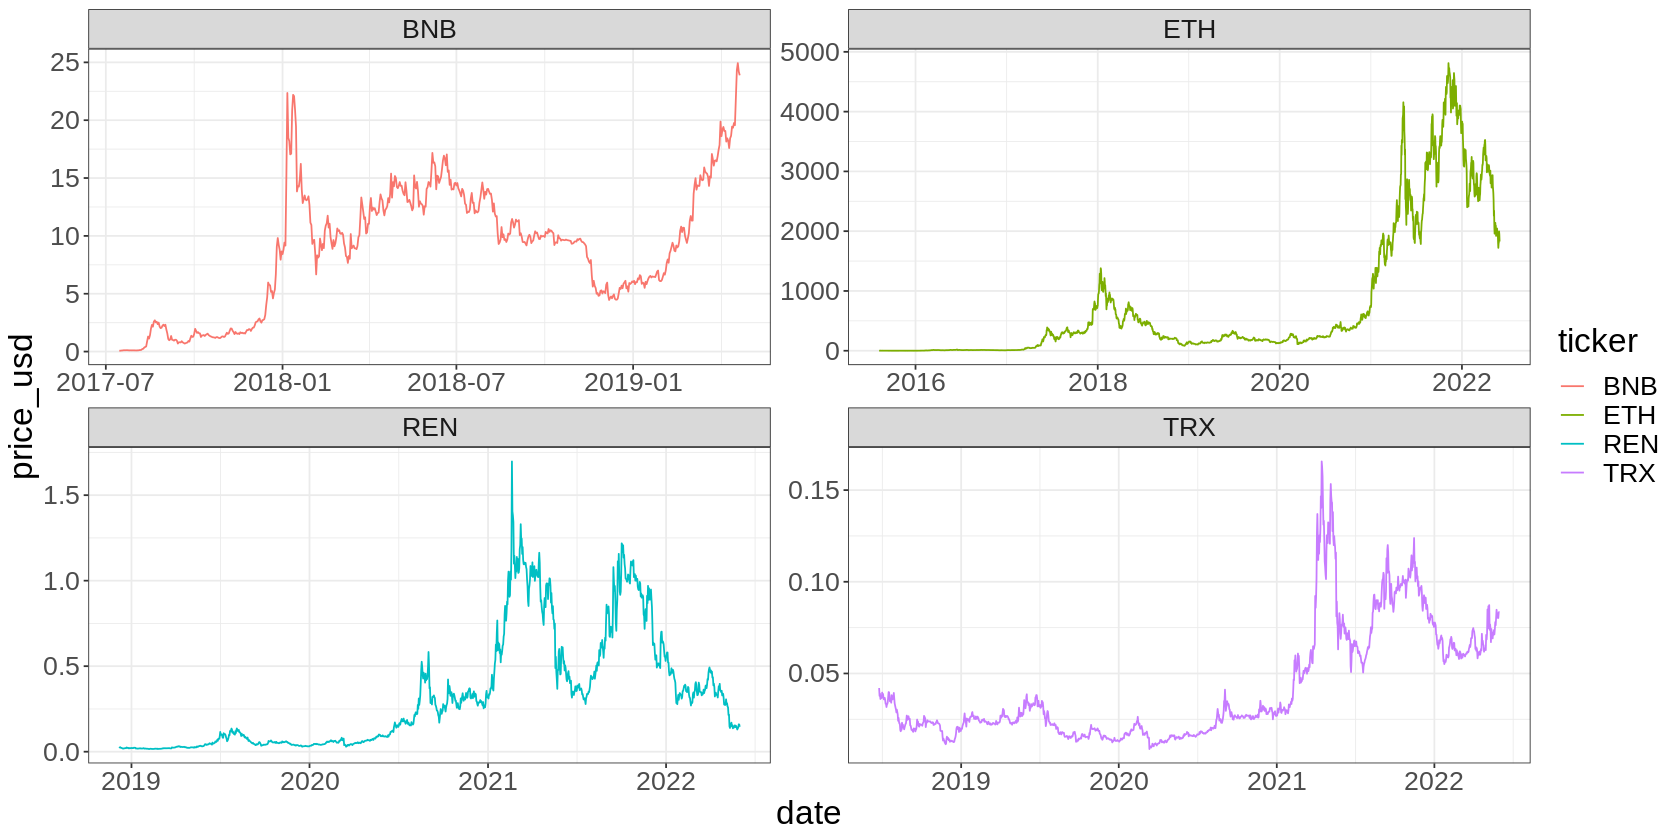

In [5]:
prices %>%
  mutate(first3 = str_sub(ticker, 1,3)) %>%
  filter(first3 %in% c('BNB','ETH','LEO','REN','TRX')) %>%
  group_by(first3, ticker) %>%
  summarise(observations = n(),
            start_date = min(date),
            end_date = max(date)) %>%
  arrange(first3, start_date)

  prices %>% 
    mutate(first3 = str_sub(ticker, 1,3)) %>%
    filter(first3 %in% c('BNB','ETH','LEO','REN','TRX')) %>%
    ggplot(aes(x=date, y = price_usd, color = ticker)) + 
      geom_line() +
      facet_wrap(~first3, scales = 'free')

## BNB 

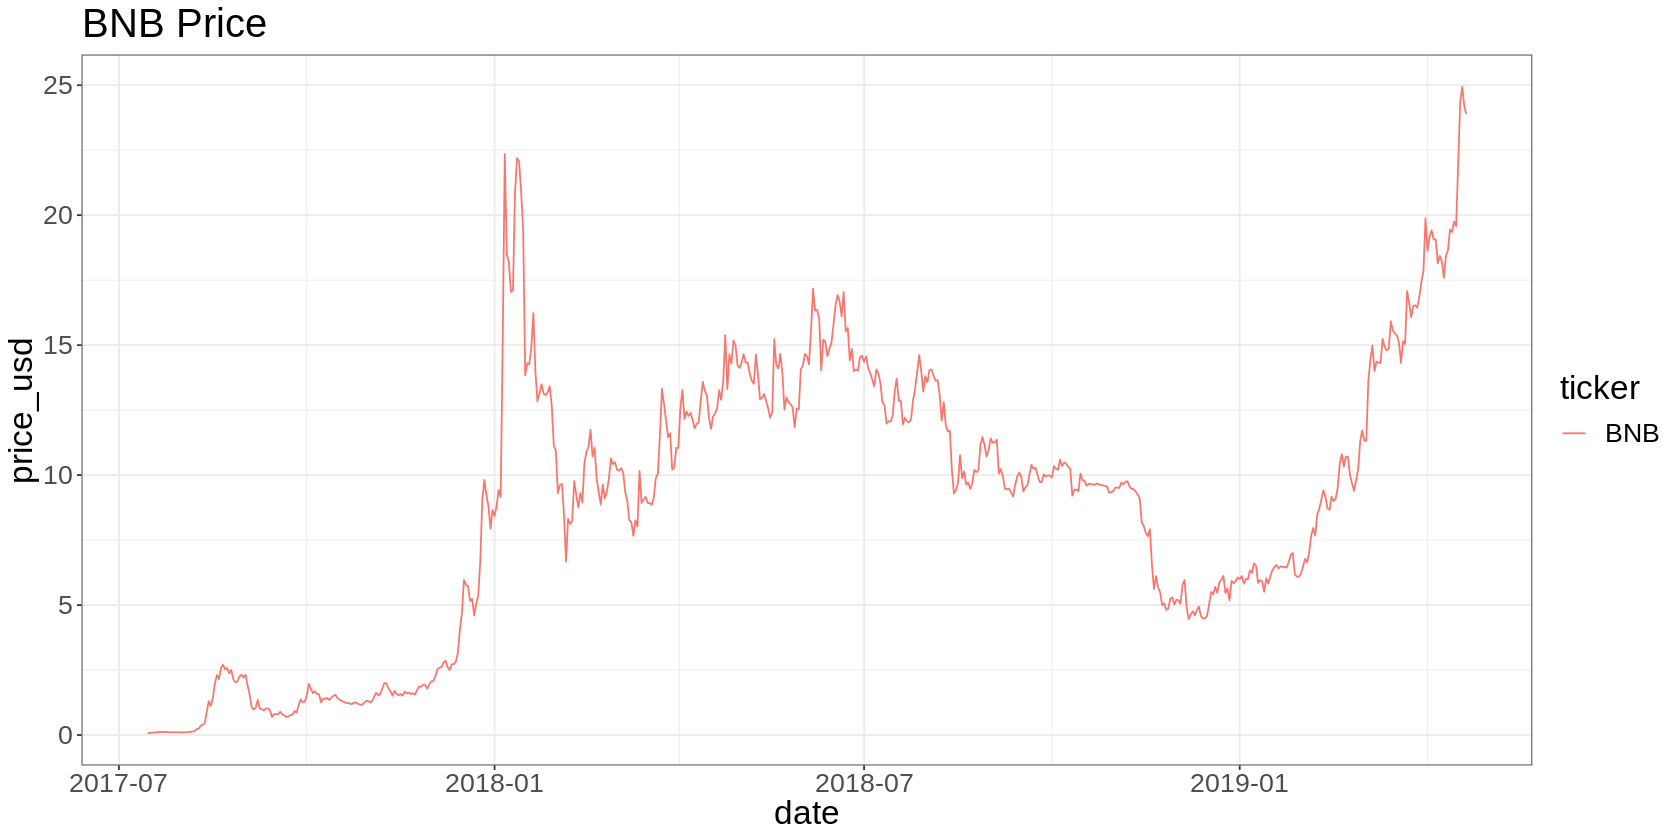

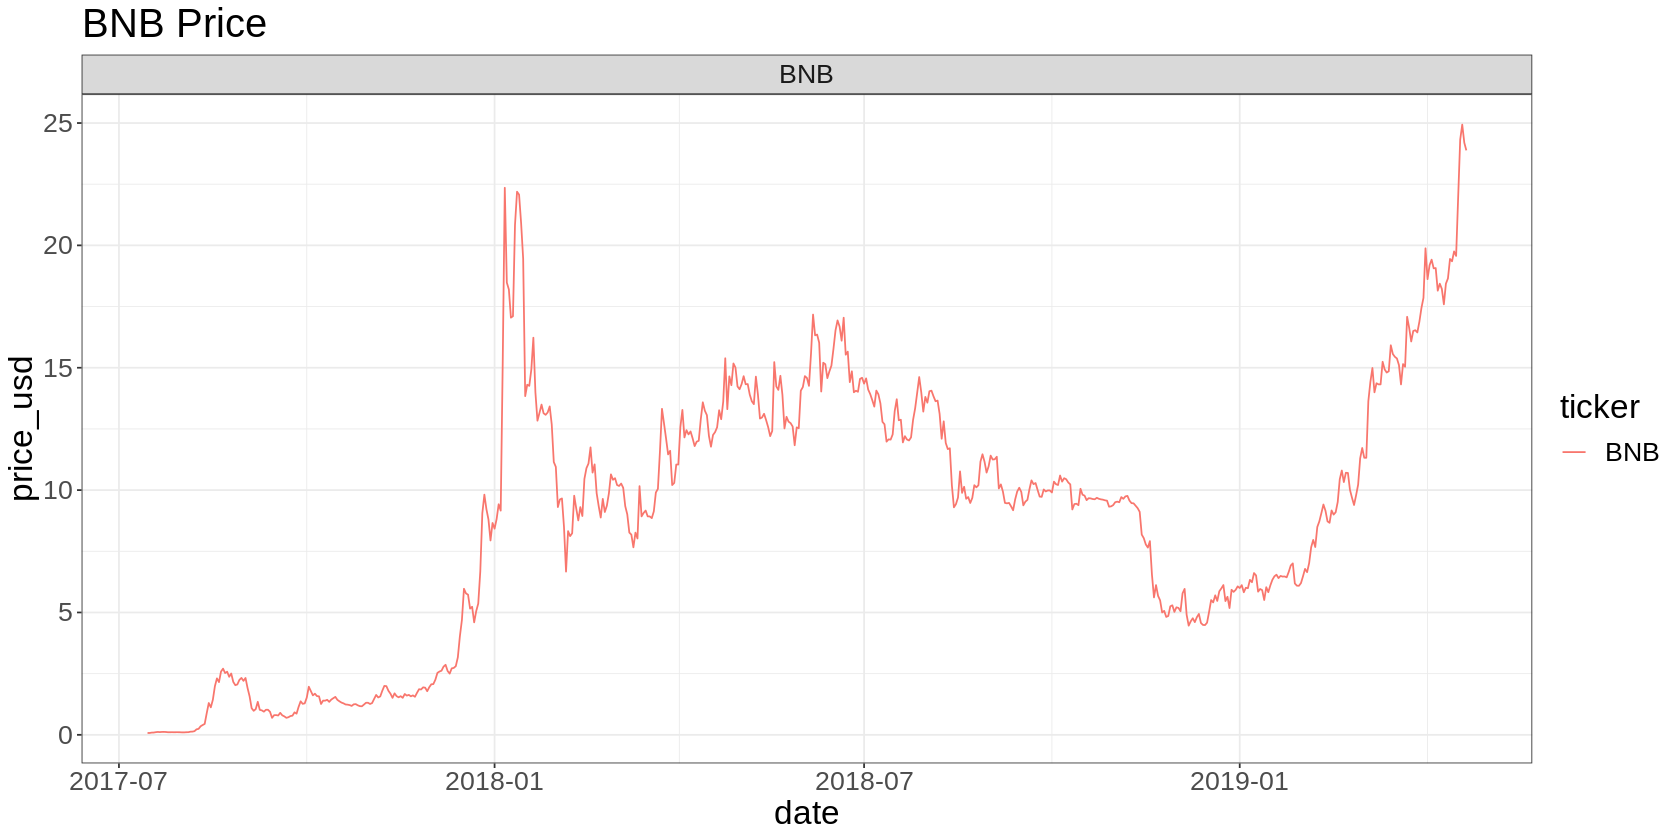

In [6]:
prices %>%
  filter(str_detect(ticker, 'BNB')) %>%
  ggplot(aes(x=date, y=price_usd, color = ticker)) + 
     geom_line() +
     ggtitle('BNB Price')

prices %>% 
  filter(str_detect(ticker, 'BNB')) %>%
  ggplot(aes(x=date, y=price_usd, color = ticker)) + 
     geom_line() +
     facet_wrap(~ticker) +
     ggtitle('BNB Price')

The questions is... do we use BNB and BNB_ETH in the early part of the history.

Let's plot market cap

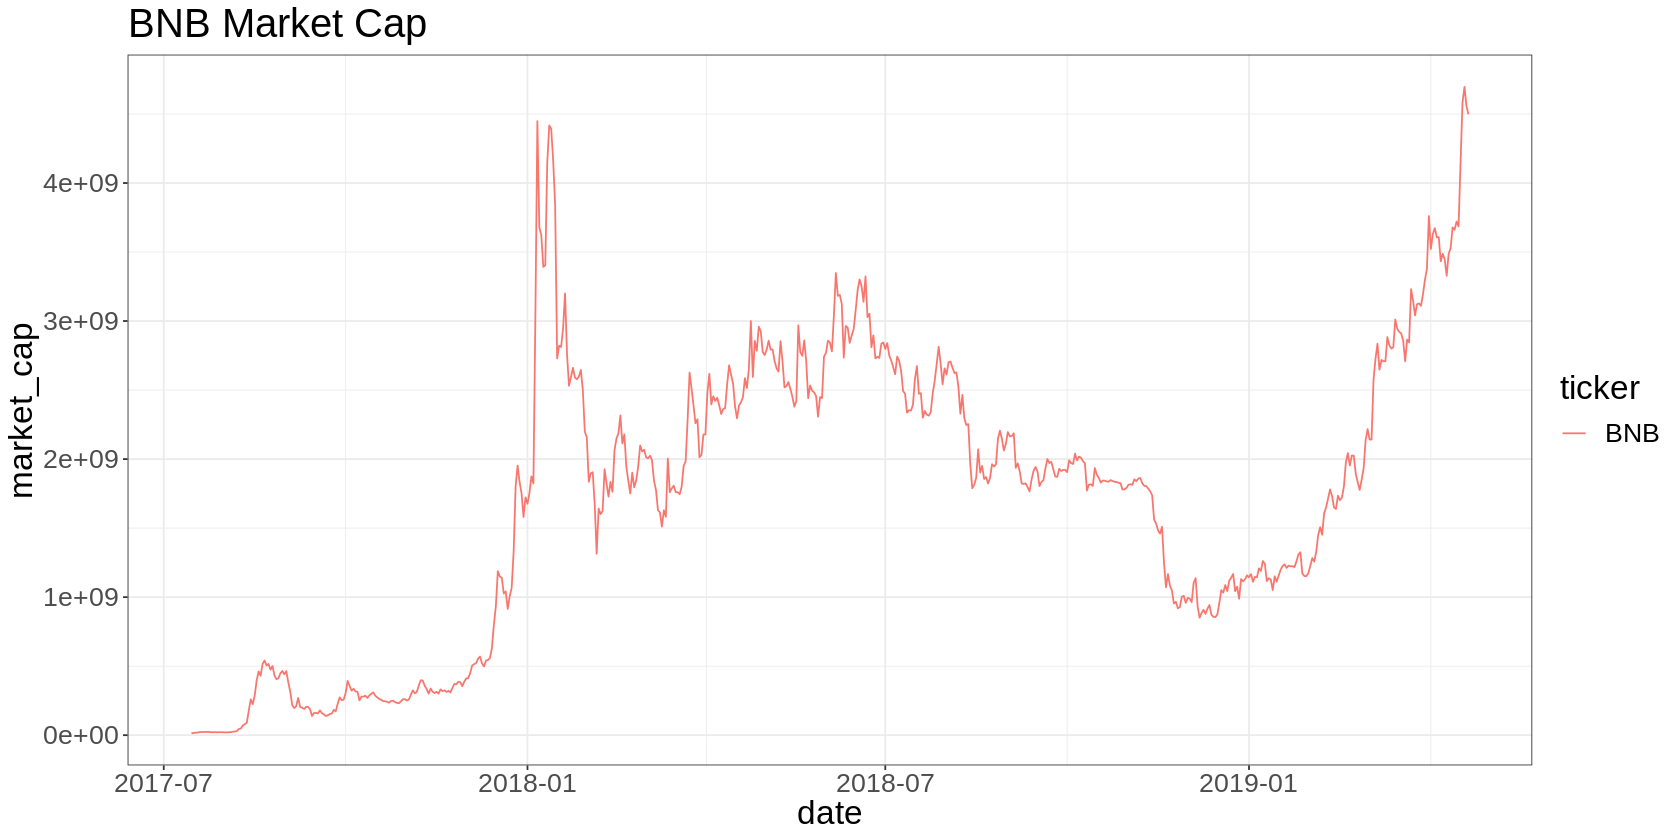

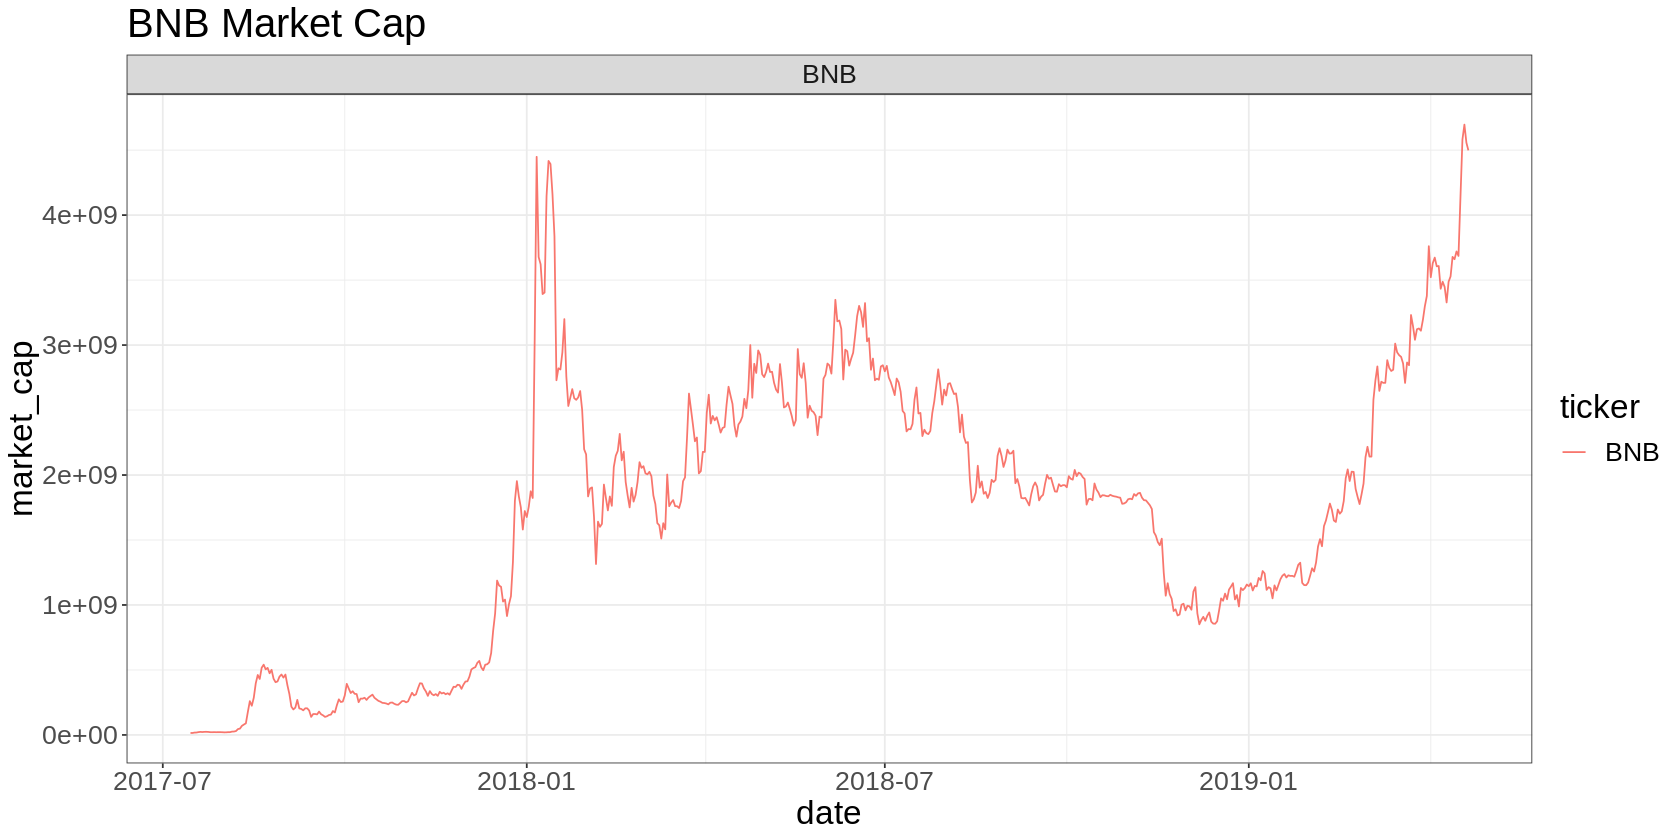

In [7]:
prices %>%
  filter(ticker %in% c('BNB','BNB_ETH')) %>%
  ggplot(aes(x=date, y=market_cap, color = ticker)) + 
    geom_line() +
    ggtitle('BNB Market Cap')

  prices %>%
  filter(ticker %in% c('BNB','BNB_ETH')) %>%
  ggplot(aes(x=date, y=market_cap, color = ticker)) + 
    geom_line() + 
    facet_wrap(~ticker) +
    ggtitle('BNB Market Cap')

They're exactly the same, so let's just remove BNB_ETH from our dataset. 

In [8]:
prices <- prices %>%
  filter(ticker != 'BNB_ETH')

## ETH and ETHOS

These are two different assets, so we don't need to do anything here.

Let's remove LEO_EOS from our data set

In [9]:
prices <- prices %>%
  filter(ticker != 'LEO_EOS')

## RENBTC

renBTC is a synthetic asset tracking the price of Bitcoin. Let's just remove it.

In [10]:
prices <- prices %>%
  filter(ticker != 'RENBTC')

## TRX

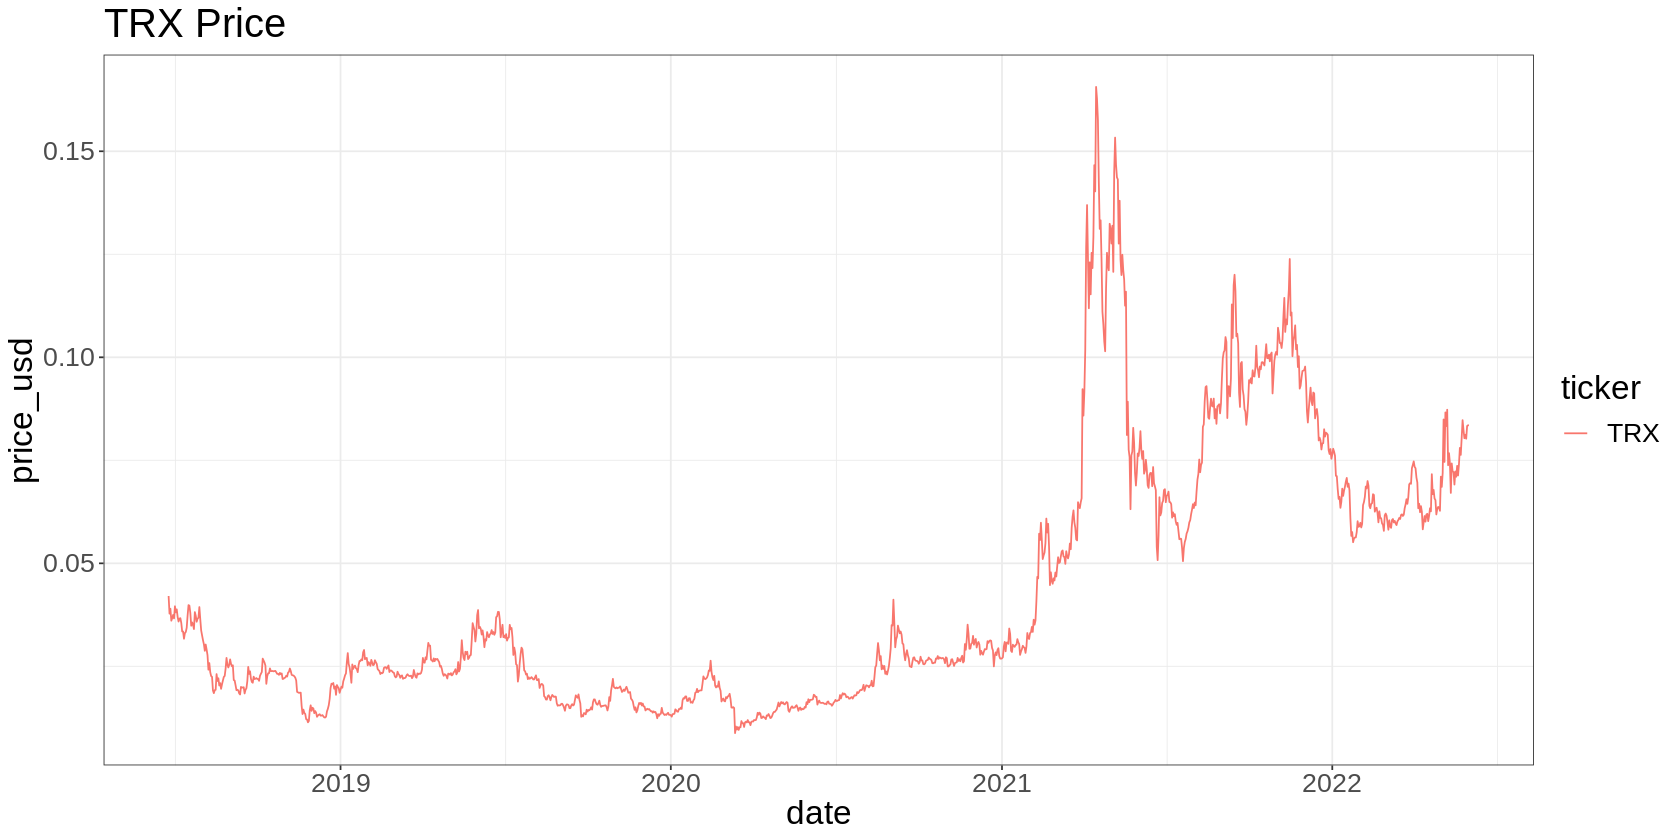

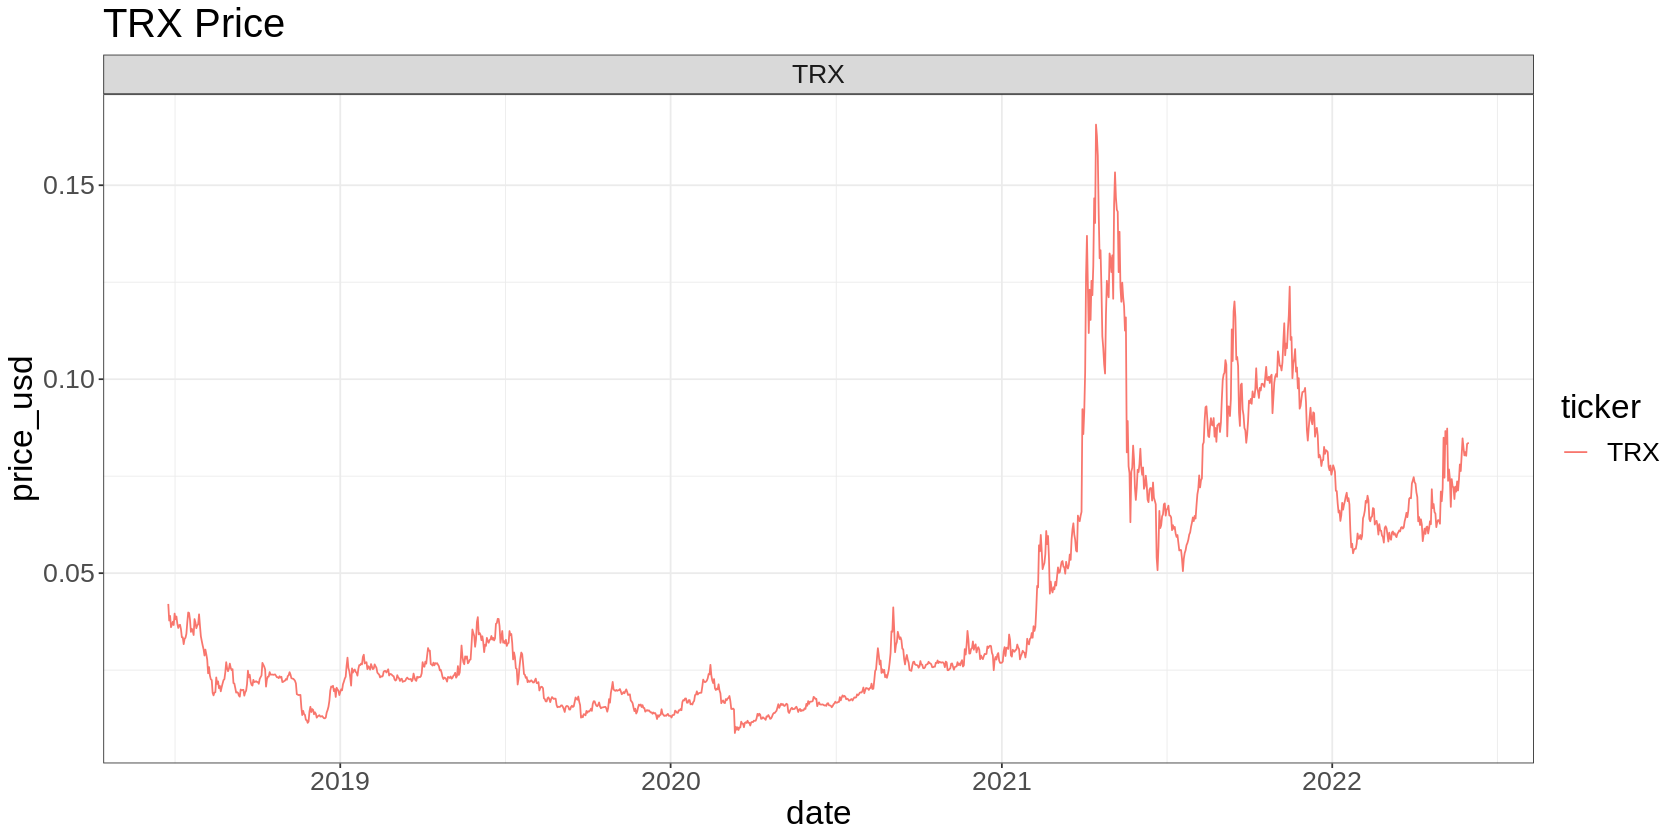

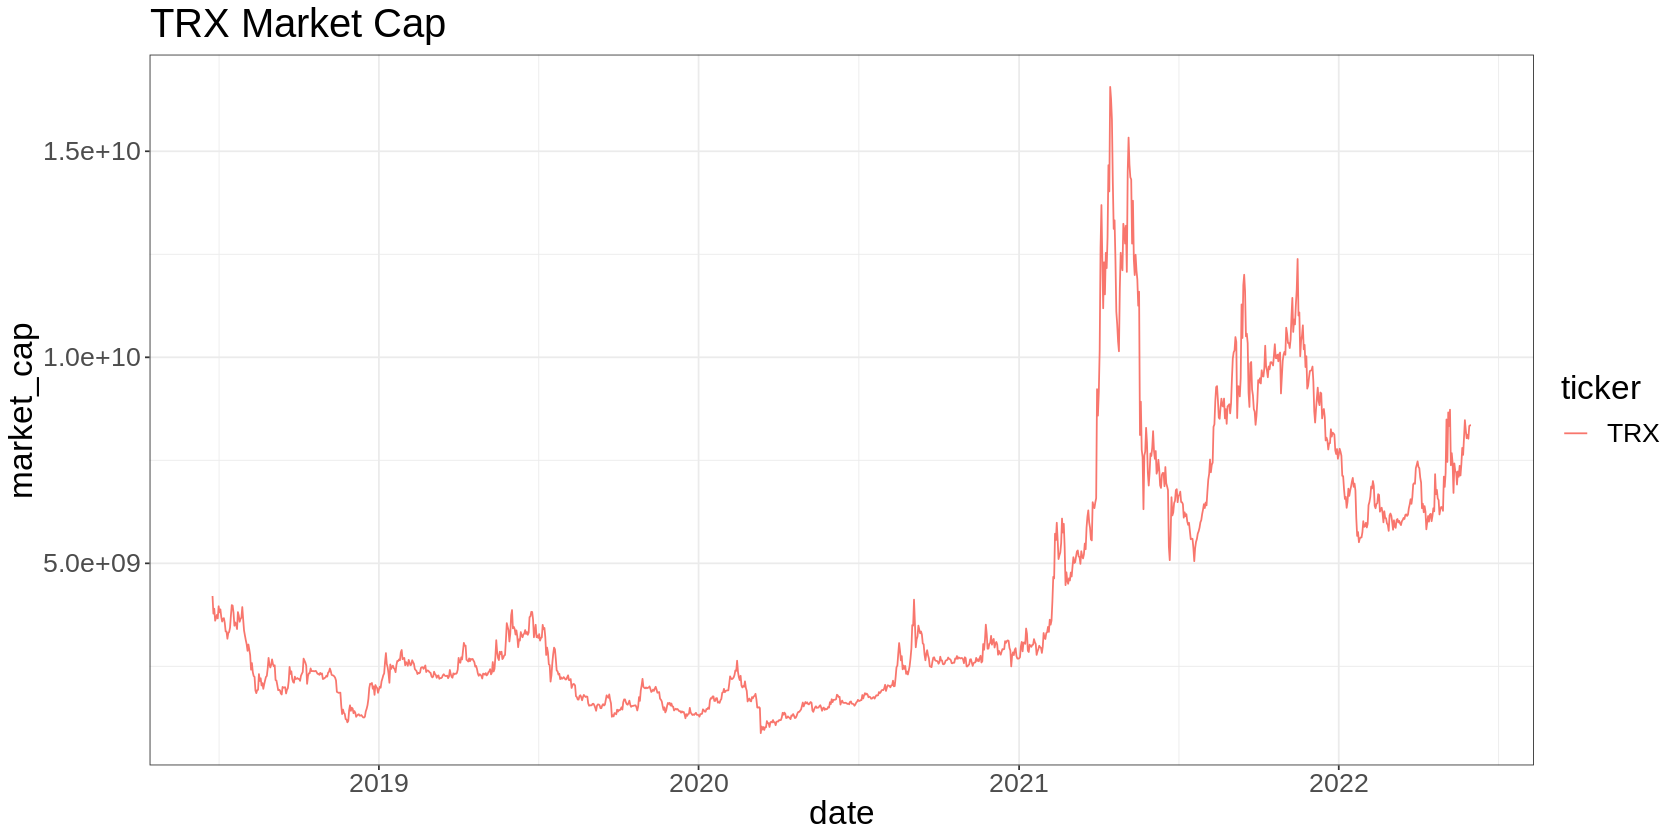

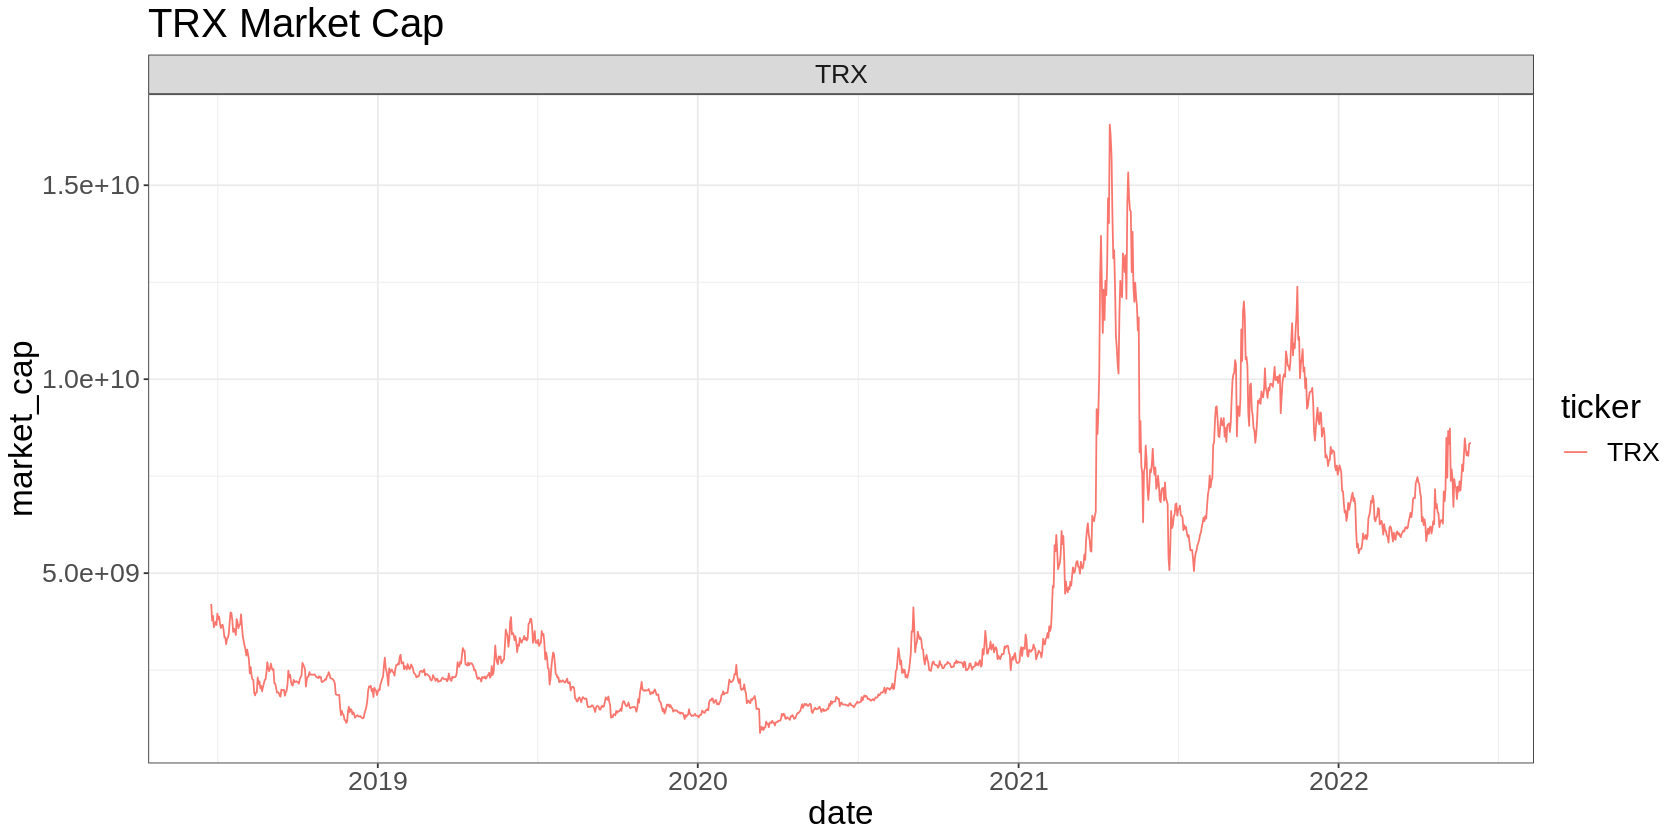

In [11]:
prices %>%
  filter(str_detect(ticker, 'TRX')) %>%
  ggplot(aes(x=date, y=price_usd, color = ticker)) + 
     geom_line() +
     ggtitle('TRX Price')

prices %>% 
  filter(str_detect(ticker, 'TRX')) %>%
  ggplot(aes(x=date, y=price_usd, color = ticker)) + 
     geom_line() +
     facet_wrap(~ticker) +
     ggtitle('TRX Price')

prices %>%
  filter(str_detect(ticker, 'TRX')) %>%
  ggplot(aes(x=date, y=market_cap, color = ticker)) + 
    geom_line() +
    ggtitle('TRX Market Cap')

  prices %>%
  filter(str_detect(ticker, 'TRX')) %>%
  ggplot(aes(x=date, y=market_cap, color = ticker)) + 
    geom_line() + 
    facet_wrap(~ticker) +
    ggtitle('TRX Market Cap')

OK to keep both of these in the universe.

In [12]:
prices %>%
  distinct(ticker) %>%
  mutate(first3 = str_sub(ticker, 1,3)) %>%
  group_by(first3) %>%
  summarise(tickercount = n()) %>%
  filter(tickercount > 1) %>%
  arrange(desc(tickercount))

prices %>%
  mutate(first3 = str_sub(ticker, 1,3)) %>%
  filter(first3 %in% c('BNB','ETH','LEO','REN','TRX')) %>%
  group_by(first3, ticker) %>%
  summarise(observations = n(),
            start_date = min(date),
            end_date = max(date)) %>%
  arrange(first3, start_date)

first3,tickercount
<chr>,<int>


`summarise()` has grouped output by 'first3'. You can override using the
`.groups` argument.


first3,ticker,observations,start_date,end_date
<chr>,<chr>,<int>,<date>,<date>
BNB,BNB,647,2017-07-15,2019-04-22
ETH,ETH,2490,2015-08-08,2022-06-01
REN,REN,1273,2018-12-07,2022-06-01
TRX,TRX,1438,2018-06-25,2022-06-01


Other problem children in our dataset may be "wrapped" coins... they usually begin with "W"

In [13]:
prices %>%
  group_by(ticker) %>%
  summarise(observations = n(),
            start_date = min(date),
            end_date = max(date)) %>%
  arrange(desc(ticker)) %>% 
  head(20)

ticker,observations,start_date,end_date
<chr>,<int>,<date>,<date>
ZRX,1756,2017-08-11,2022-06-01
YFI,677,2020-07-25,2022-06-01
XRP,2848,2014-08-15,2022-06-01
WBTC,1286,2018-11-24,2022-06-01
UNI,622,2020-09-18,2022-06-01
TRX,1438,2018-06-25,2022-06-01
SUSHI,639,2020-09-01,2022-06-01
SRM,660,2020-08-11,2022-06-01
SNX,784,2020-04-09,2022-06-01


Remove the wrapped tokens: WNXM, WETH and WBTC

In [14]:
prices <- prices %>%
  filter(!ticker %in% c('WNXM','WETH','WBTC'))

Let's put this filtering in a single statement, to reuse in other notebooks. 

In [15]:
# snippet: rw crypto remove duplicates v0.1
# Remove duplicate protocol coins from data set
prices <- prices %>% 
  filter(!ticker %in% c('BNB_ETH','LEO_EOS','RENBTC', 'WNXM', 'WETH', 'WBTC'))

# Creating a market cap index to analyze

To create a non-biases universe we want to select the top n assets by marketcap (from the day before.)

Start our analysis in early 2015, when we have 10 assets in our universe.

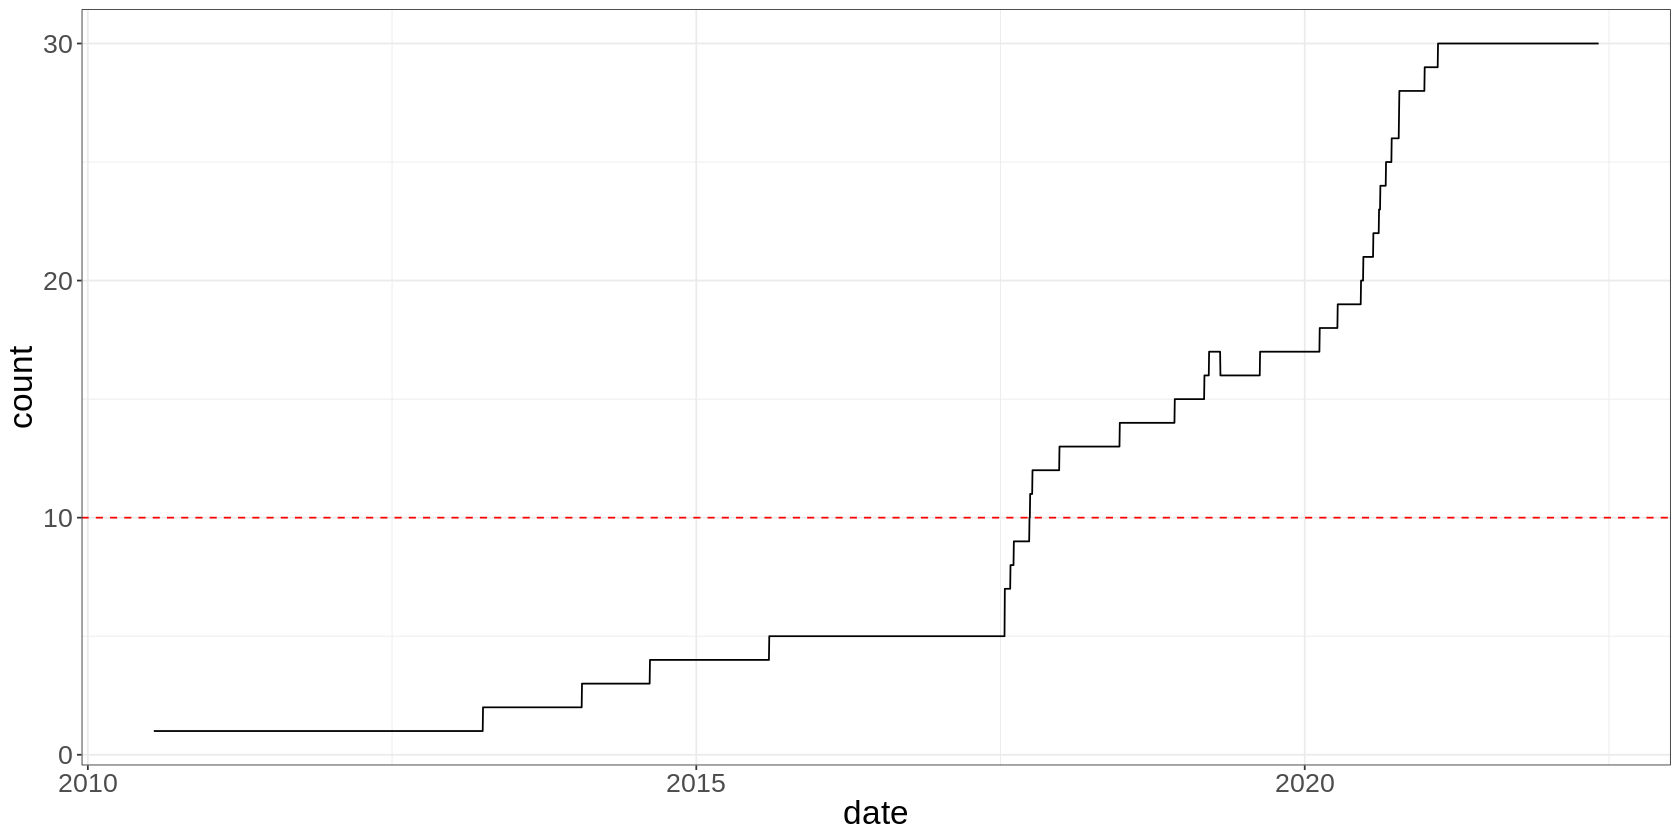

In [16]:
prices %>%
  group_by(date) %>%
  summarise(count = n()) %>%
  ggplot(aes(x=date, y = count)) + geom_line() + geom_hline(yintercept = 10, linetype = 'dashed', color = 'red')

In [17]:
prices %>%
  group_by(date) %>%
  summarise(count = n()) %>%
  filter(count >= 10) %>%
  summarise(min(date))

min(date)
<date>
2017-09-27


For a given ticker/date observation, set is_index to TRUE if:
 - the asset was in the top 10 coins by market cap the day before
 - the date is on or after 2015-04-02 (when our analysis universe starts)

In [18]:
universe <- prices %>%
  group_by(date) %>%
  mutate(cap_rank = row_number(desc(market_cap))) %>%
  arrange(date) %>%
  group_by(ticker) %>%
  mutate(is_index = lag(cap_rank) <= 10 & date >= '2015-04-01') %>%
  na.omit()

Let's look at the unique assets in our universe...

In [19]:
universe %>%
  filter(is_index) %>%
  group_by(ticker) %>%
  summarise(observations = n(),
            start_date = min(date),
            end_date = max(date)) %>%
  arrange(ticker)

ticker,observations,start_date,end_date
<chr>,<int>,<date>,<date>
1INCH,24,2020-12-27,2021-03-18
AAVE,19,2021-01-24,2021-02-13
BAT,164,2017-10-07,2019-05-11
BCH,1624,2017-08-02,2022-04-21
BNB,646,2017-07-16,2019-04-22
BTC,2619,2015-04-01,2022-06-01
COMP,59,2020-06-19,2020-09-02
CRO,1160,2019-03-21,2022-06-01
CRV,58,2020-08-16,2022-01-20


We have a couple of days of overlap between BNB and BNB_BC, but I'm not too worried about that.

Let's look at the first consituents

In [20]:
universe %>% 
  ungroup() %>%
  filter(is_index) %>%
  filter(date == min(date)) %>%
  arrange(cap_rank)


ticker,date,price_usd,market_cap,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>
BTC,2015-04-01,2.471858e+02,3462409579,1,TRUE
XRP,2015-04-01,7.674863e-03,767479678,2,TRUE
LTC,2015-04-01,1.668453e+00,63053937,3,TRUE
DOGE,2015-04-01,1.262558e-04,12476174,4,TRUE


And the latest ones...

In [21]:
universe %>% 
  ungroup() %>%
  filter(is_index) %>%
  filter(date == max(date)) %>%
  arrange(cap_rank)

ticker,date,price_usd,market_cap,cap_rank,is_index
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>
BTC,2022-06-01,2.982592e+04,568350982618,1,TRUE
ETH,2022-06-01,1.827637e+03,216807727249,2,TRUE
XRP,2022-06-01,3.983263e-01,39828407681,3,TRUE
CRO,2022-06-01,1.786233e-01,17862332220,4,TRUE
DOGE,2022-06-01,8.104654e-02,10913966312,5,TRUE
FTT,2022-06-01,2.693313e+01,8939517454,6,TRUE
TRX,2022-06-01,8.351603e-02,8351602627,7,TRUE
LINK,2022-06-01,6.927310e+00,6927310231,8,TRUE
UNI,2022-06-01,5.168436e+00,5168436074,9,TRUE


# Function to Flag Universe Consituents

In [22]:
# snippet: rw crypto flag universe consituents v0.1
create_universe <- function(prices, n=10, min_constituents = 10) {
  # snippet: rw crypto remove stablecoins v0.2
  # Remove stablecoins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BUSD','DAI','GUSD','HUSD','PAX','SAI','TUSD','USDC','USDK','USDT','USDT_ETH','USDT_OMNI','USDT_TRX', 'XAUT')) 
  # snippet: rw crypto remove duplicates v0.1
  # Remove duplicate protocol coins from data set
  prices <- prices %>% 
    filter(!ticker %in% c('BNB_ETH','LEO_EOS','RENBTC', 'WNXM', 'WETH', 'WBTC'))

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(date)) %>%
    pull(mindate)

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  prices %>%
    group_by(date) %>%
    mutate(cap_rank = row_number(desc(market_cap))) %>%
    arrange(date) %>%
    group_by(ticker) %>%
    mutate(is_index = lag(cap_rank) <= 10 & date >= '2015-04-01') %>%
    na.omit() %>%
    ungroup()
}

Let's call it on fresh data and check we got the same result as before

In [23]:
freshprices <- rwRtools::crypto_get_coinmetrics()
universe_check <- create_universe(freshprices, n = 10, min_constituents = 10) 

ℹ Downloading coinmetrics.csv

✔ Saved coinmetrics.csv to coinmetrics/coinmetrics.csv  ( 2.4 Mb )





File successfully transferred


Rows: 49183 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (2): price_usd, market_cap
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [24]:
universe %>% print()
universe_check %>% print()

# A tibble: 43,320 × 6
# Groups:   ticker [31]
   ticker date       price_usd market_cap cap_rank is_index
   <chr>  <date>         <dbl>      <dbl>    <int> <lgl>   
 1 BTC    2010-07-18    0.0858    295959.        1 FALSE   
 2 BTC    2010-07-19    0.0808    279285.        1 FALSE   
 3 BTC    2010-07-20    0.0747    259000.        1 FALSE   
 4 BTC    2010-07-21    0.0792    275266.        1 FALSE   
 5 BTC    2010-07-22    0.0585    203750.        1 FALSE   
 6 BTC    2010-07-23    0.0606    211736.        1 FALSE   
 7 BTC    2010-07-24    0.0545    191100.        1 FALSE   
 8 BTC    2010-07-25    0.0505    177670.        1 FALSE   
 9 BTC    2010-07-26    0.056     197543.        1 FALSE   
10 BTC    2010-07-27    0.0586    207279.        1 FALSE   
# … with 43,310 more rows
# A tibble: 43,320 × 6
   ticker date       price_usd market_cap cap_rank is_index
   <chr>  <date>         <dbl>      <dbl>    <int> <lgl>   
 1 BTC    2010-07-18    0.0858    295959.        1 FALSE   
 2 B

In [25]:
diffs <- (universe == universe_check) 
diffs[diffs == FALSE]

logical(0)

# Basic Analysis of Universe

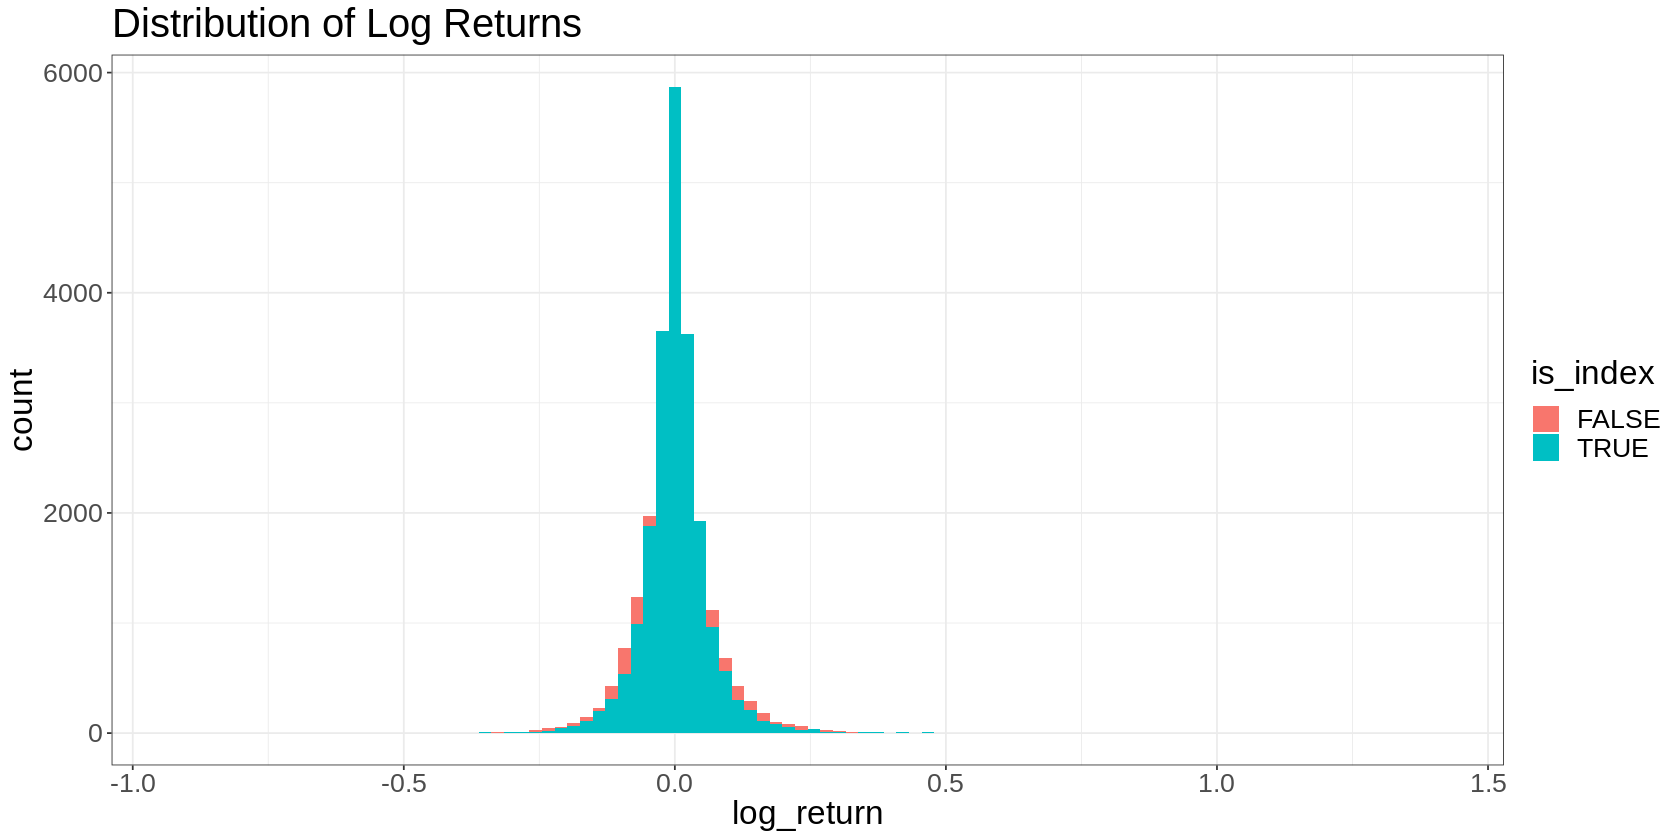

In [26]:
# snippet: rw crypto calc periodic returns v.0.1
# Calculate log and simple returns at the same periodicity as your data.
# Assumes there are no gaps in your data and your price column is price_usd (as it is in default coinmetrics data) 
returns <- universe %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(log_return = log(price_usd / lag(price_usd, n = 1))) %>%
  mutate(simple_return = price_usd / lag(price_usd, n = 1) - 1) %>%
  na.omit() %>%
  ungroup()

  # snippet: rw crypto plot return histogram v.0.1
returns %>%
  ggplot(aes(x = log_return, fill = is_index)) +
    geom_histogram(position = 'identity', bins = 100) +
    ggtitle('Distribution of Log Returns')

In [27]:
returns %>% 
  group_by(is_index) %>%
  summarise(count = n(),
            min_return = min(log_return), 
            max_return = max(log_return), 
            mean = mean(log_return),
            median = median(log_return), 
            sd = sd(log_return))

is_index,count,min_return,max_return,mean,median,sd
<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,21549,-0.9044716,1.407060,0.0009470346,1.634128e-05,0.07388739
TRUE,21740,-0.6364941,1.015889,0.0012664451,2.145670e-04,0.06503060


There are large tails and significant upward bias in our dataset.

The fact that the stuff in our index has 2x the mean return of stuff outside, suggests that the Coinmetrics universe itself may be introducing upward bias to our analysis.

We must be careful to make sure we bear this in mind in our analysis, and ensure that any factors are analyzed as long/short factors as well as long only to try to control for this potential bias as best we can. 

## An Equal Weighted Index

Here we construct an index which is our index constituents equal weighted and rebalanced daily. 

And compare that to a long only allocation to BTC.

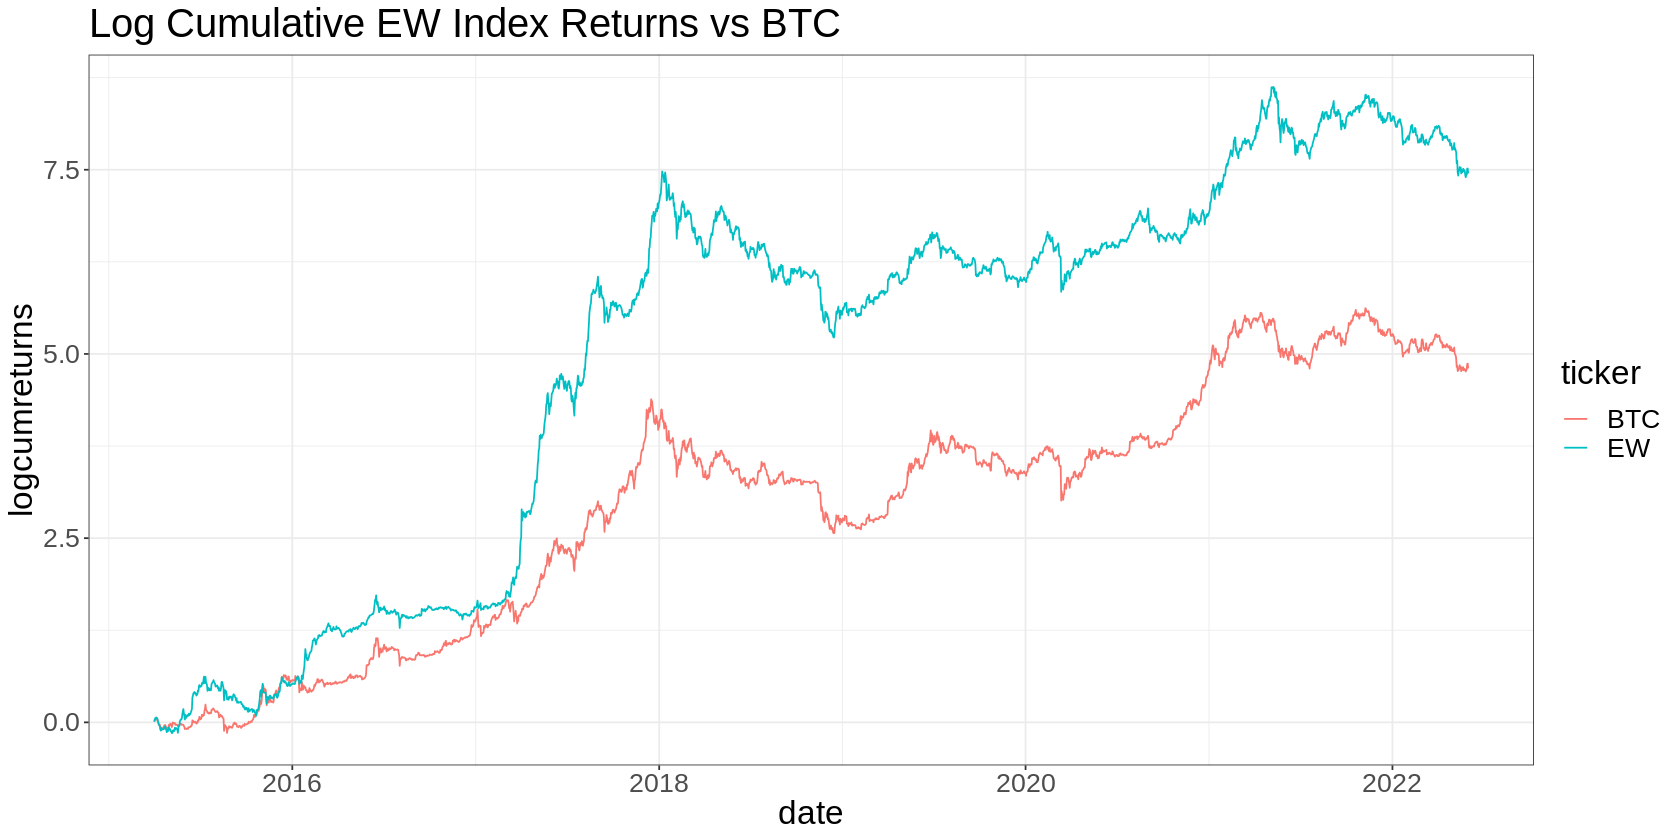

In [28]:
EWreturns <- returns %>%
  filter(is_index) %>%
  group_by(date) %>%
  summarise(index_return = mean(simple_return)) %>%
  ungroup() %>%
  arrange(date) %>%
  mutate(logcumreturns = log(cumprod(1+index_return)),
         ticker = 'EW') %>%
  select(ticker, date, logcumreturns)

start_date <- EWreturns %>% 
  summarise(mindate = min(date)) %>%
  pull(mindate)

BTCreturns <- returns %>%
  filter(date >= start_date) %>%
  filter(ticker == 'BTC') %>%
  mutate(logcumreturns = log(cumprod(1+simple_return))) %>%
  select(ticker, date, logcumreturns)

BTCreturns %>%
  bind_rows(EWreturns) %>%
  ggplot(aes(x=date, y=logcumreturns, color=ticker)) + 
    geom_line() + 
    ggtitle('Log Cumulative EW Index Returns vs BTC')